In [2]:
# Import libraries
import os, glob, io, pickle,random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook

In [3]:
### Functions to load and dump existing structure from/to files
def load_file(current_path,filename):
    print("Loading the file: ",filename)
    with open(current_path+filename,'rb') as pickle_file:
        cfile=pickle.load(pickle_file)
    return(cfile)

def dump_file(current_path,filename,data_structure):
    if os.path.isfile(current_path+filename) and os.access(current_path, os.R_OK):
        # checks if file exists
        print ("File exists and is readable")
        current_file=load_file(current_path,filename)
        return(current_file)
    else:
        if data_structure == [] or data_structure == {}:
            return data_structure
        else:
            print ("Either file is missing or is not readable, creating file...")
            with open(current_path+filename, 'wb') as outfile:
                pickle.dump(data_structure, outfile)
            return(1)


##### Loading the length of each movie in a dictionary

In [4]:
filepath_films='./data/emo/*csv'
films_data_length={}
for index, film_label in enumerate(glob.glob(filepath_films)):
    if 'All_Annotations' not in film_label and 'labels' not in film_label \
    and 'AnnotationWeights' not in film_label and 'WeightedAnnotations' not in film_label:
        filmID=film_label.strip().split('/')[-1].split('.')[0][:-2]
        current_length=len(np.loadtxt(film_label))
        films_data_length[str(filmID.split('_')[1])]=current_length


##### Loading the fMRI data for all the movies

In [7]:
EmoResponse            = 3    
filepath_movies        = './data/fMRIFiles/TCFiles/TC_400_*'
filepath_motion_scores = './data/fMRIFiles/MCFiles/prefiltered_func_data_mcf_rel_'
remove_motion          = True
motion_thresh          = 0.5

data_subject_movies       = {}
frame_displacement_movies = {}

##Loading movie data
for index,current_fp in enumerate(tqdm_notebook(sorted(glob.glob(filepath_movies)))):
    if 'Rest' not in current_fp:
        subjID    = current_fp.strip().split('/')[-1].split('_')[2]
        sessionID = current_fp.strip().split('/')[-1].split('_')[3]
        movieID   = current_fp.strip().split('/')[-1].split('_')[-1].split('.')[0]

        if subjID not in data_subject_movies:
            data_subject_movies[subjID] = {}
        if subjID not in frame_displacement_movies:
            frame_displacement_movies[subjID] = {}
        ## Loading the data and removing the first and last part of the recordings ( 72 TR + EmoResponse)
        ## (rest before and after each movie)
        #print(index,current_fp,subjID,movieID,films_data_length[movieID])

        c_movie_loaded = np.loadtxt(current_fp,delimiter=',')
        temporary_data=c_movie_loaded[(72+EmoResponse):(72+EmoResponse)+films_data_length[movieID],:]    

        if remove_motion == True:
            ##Opening the motion scores
            motion_path = filepath_motion_scores+subjID+"_"+sessionID+"_"+movieID+".csv"

            ##File with frame displacement
            fd_file     = np.loadtxt(motion_path)[(72+EmoResponse+1):(72+EmoResponse)+films_data_length[movieID]+1]

            ##Find the indexes where motion is lower than threshold
            indexes_no_motion   = np.where(fd_file<motion_thresh)[0]
            ##Find the indexes where motion is greater or equal than threshold
            indexes_with_motion = np.where(fd_file>=motion_thresh)[0]


            ## Set to NaN values that are with motion
            temporary_data[indexes_with_motion,:] = np.nan
            ##For each subject and each movie, save the info about number of frames with no motion,
            ##motion, and the percentage of motion in a list 
            frame_displacement_movies[subjID][movieID] = [len(indexes_no_motion),len(indexes_with_motion),
                                 len(indexes_with_motion)/(len(indexes_with_motion)+len(indexes_no_motion))]

            data_subject_movies[subjID][movieID] = temporary_data
        else:
            data_subject_movies[subjID][movieID] = temporary_data

    

  0%|          | 0/450 [00:00<?, ?it/s]

In [12]:
data_subject_movies['sub-S01']['BigBuckBunny'].shape

(377, 400)

(250.0, 300.0)

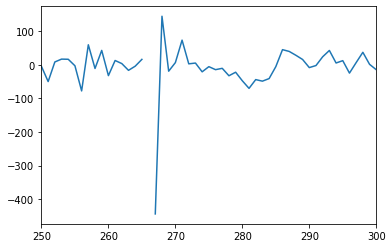

In [14]:
plt.plot(data_subject_movies['sub-S01']['BigBuckBunny'][:,0])
plt.xlim(250,300)

In [28]:
data_subject_movies['sub-S01'].keys()

dict_keys(['BigBuckBunny', 'FirstBite', 'YouAgain', 'AfterTheRain', 'LessonLearned', 'Payload', 'TheSecretNumber', 'BetweenViewings', 'Chatter', 'Spaceman', 'ToClaireFromSonny', 'Sintel', 'Superhero', 'TearsOfSteel'])

In [23]:
data_subject_movies['sub-S01']['BigBuckBunny'].shape

(375, 400)